In [6]:
import time
import toml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Optional, List
from datetime import datetime, timezone

from binance.client import Client
from binance.websockets import BinanceSocketManager

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({'font.size': 18})

In [7]:
cfg = toml.load("configuration.toml")
pkey = cfg["auth"]["pkey"]
skey = cfg["auth"]["skey"]

client = Client(pkey, skey)

# Websocket trading

Seems like the way to go - you hand a callback to a stream (1 Hz) of data. It is a rolling window over the previous 24 hrs (e.g. 1 PM yesterday to 1 PM today). Depending on the last price, best bid price, or best ask price, we can decide to make a trade or not. If speed is the primary benefit, Market Orders will take the first possible open bid/ask. It may not give the best price, but will execute instantly, and if we are quick, we will get the best bid/ask price which are listed in the socket stream.

### Ticker-symbol websocket stream format

```json
{
  "e": "24hrTicker",  // Event type
  "E": 123456789,     // Event time
  "s": "BNBBTC",      // Symbol
  "p": "0.0015",      // Price change
  "P": "250.00",      // Price change percent
  "w": "0.0018",      // Weighted average price
  "x": "0.0009",      // First trade(F)-1 price (first trade before the 24hr rolling window)
  "c": "0.0025",      // Last price
  "Q": "10",          // Last quantity
  "b": "0.0024",      // Best bid price
  "B": "10",          // Best bid quantity
  "a": "0.0026",      // Best ask price
  "A": "100",         // Best ask quantity
  "o": "0.0010",      // Open price
  "h": "0.0025",      // High price
  "l": "0.0010",      // Low price
  "v": "10000",       // Total traded base asset volume
  "q": "18",          // Total traded quote asset volume
  "O": 0,             // Statistics open time
  "C": 86400000,      // Statistics close time
  "F": 0,             // First trade ID
  "L": 18150,         // Last trade Id
  "n": 18151          // Total number of trades
}
```

In [8]:
class unique_time_dict:
    # Got duplicates from the stream, so create a wrapper
    # to dicts which implement hash/eq so can be added to sets
    def __init__(self, d):
        self._d = d

    def __repr__(self):
        return dict.__repr__(self._d)

    def __hash__(self):
        return self._d["E"]
    
    def __eq__(self, other):
        return self._d["E"] == other["E"]
    
    def __ne__(self, other):
        return not self == other

    def __getitem__(self, k):
        return self._d[k]
    
    def __setitem__(self, k, v):
        self._d[k] = v

In [9]:
s, dups = set(), 0
def cb(msg):
    global s, dups
    drata = unique_time_dict(msg)
    if drata in s: dups += 1
    s.add(drata)


bm = BinanceSocketManager(client)
bm.start_symbol_ticker_socket('DOGEBTC', cb)
bm.start()
time.sleep(600)


from twisted.internet import reactor
reactor.stop()
# bm.stop_socket("DOGEUSDT")  # somehow this doesn't work

## Saving Data

In [11]:
ws_data = sorted([v._d for v in s], key=lambda v: float(v["E"]))
websocket_data = pd.DataFrame.from_records(ws_data, coerce_float=True)
websocket_data.to_pickle(f"./ws_data{time.time()}.pkl")

In [12]:
times = []
last_price = []
last_quantity = []
best_bid_price = []
best_bid_quantity = []
best_ask_price = []
best_ask_quantity = []

for ws_d in ws_data:
    times.append(float(ws_d["E"]))
    last_price.append(float(ws_d["c"]))
    last_quantity.append(float(ws_d["Q"]))
    best_bid_price.append(float(ws_d["b"]))
    best_bid_quantity.append(float(ws_d["B"]))
    best_ask_price.append(float(ws_d["a"]))
    best_ask_quantity.append(float(ws_d["A"]))

In [13]:
times = np.asarray(times) / 1000
best_bid_quantity = np.asarray(best_bid_quantity)

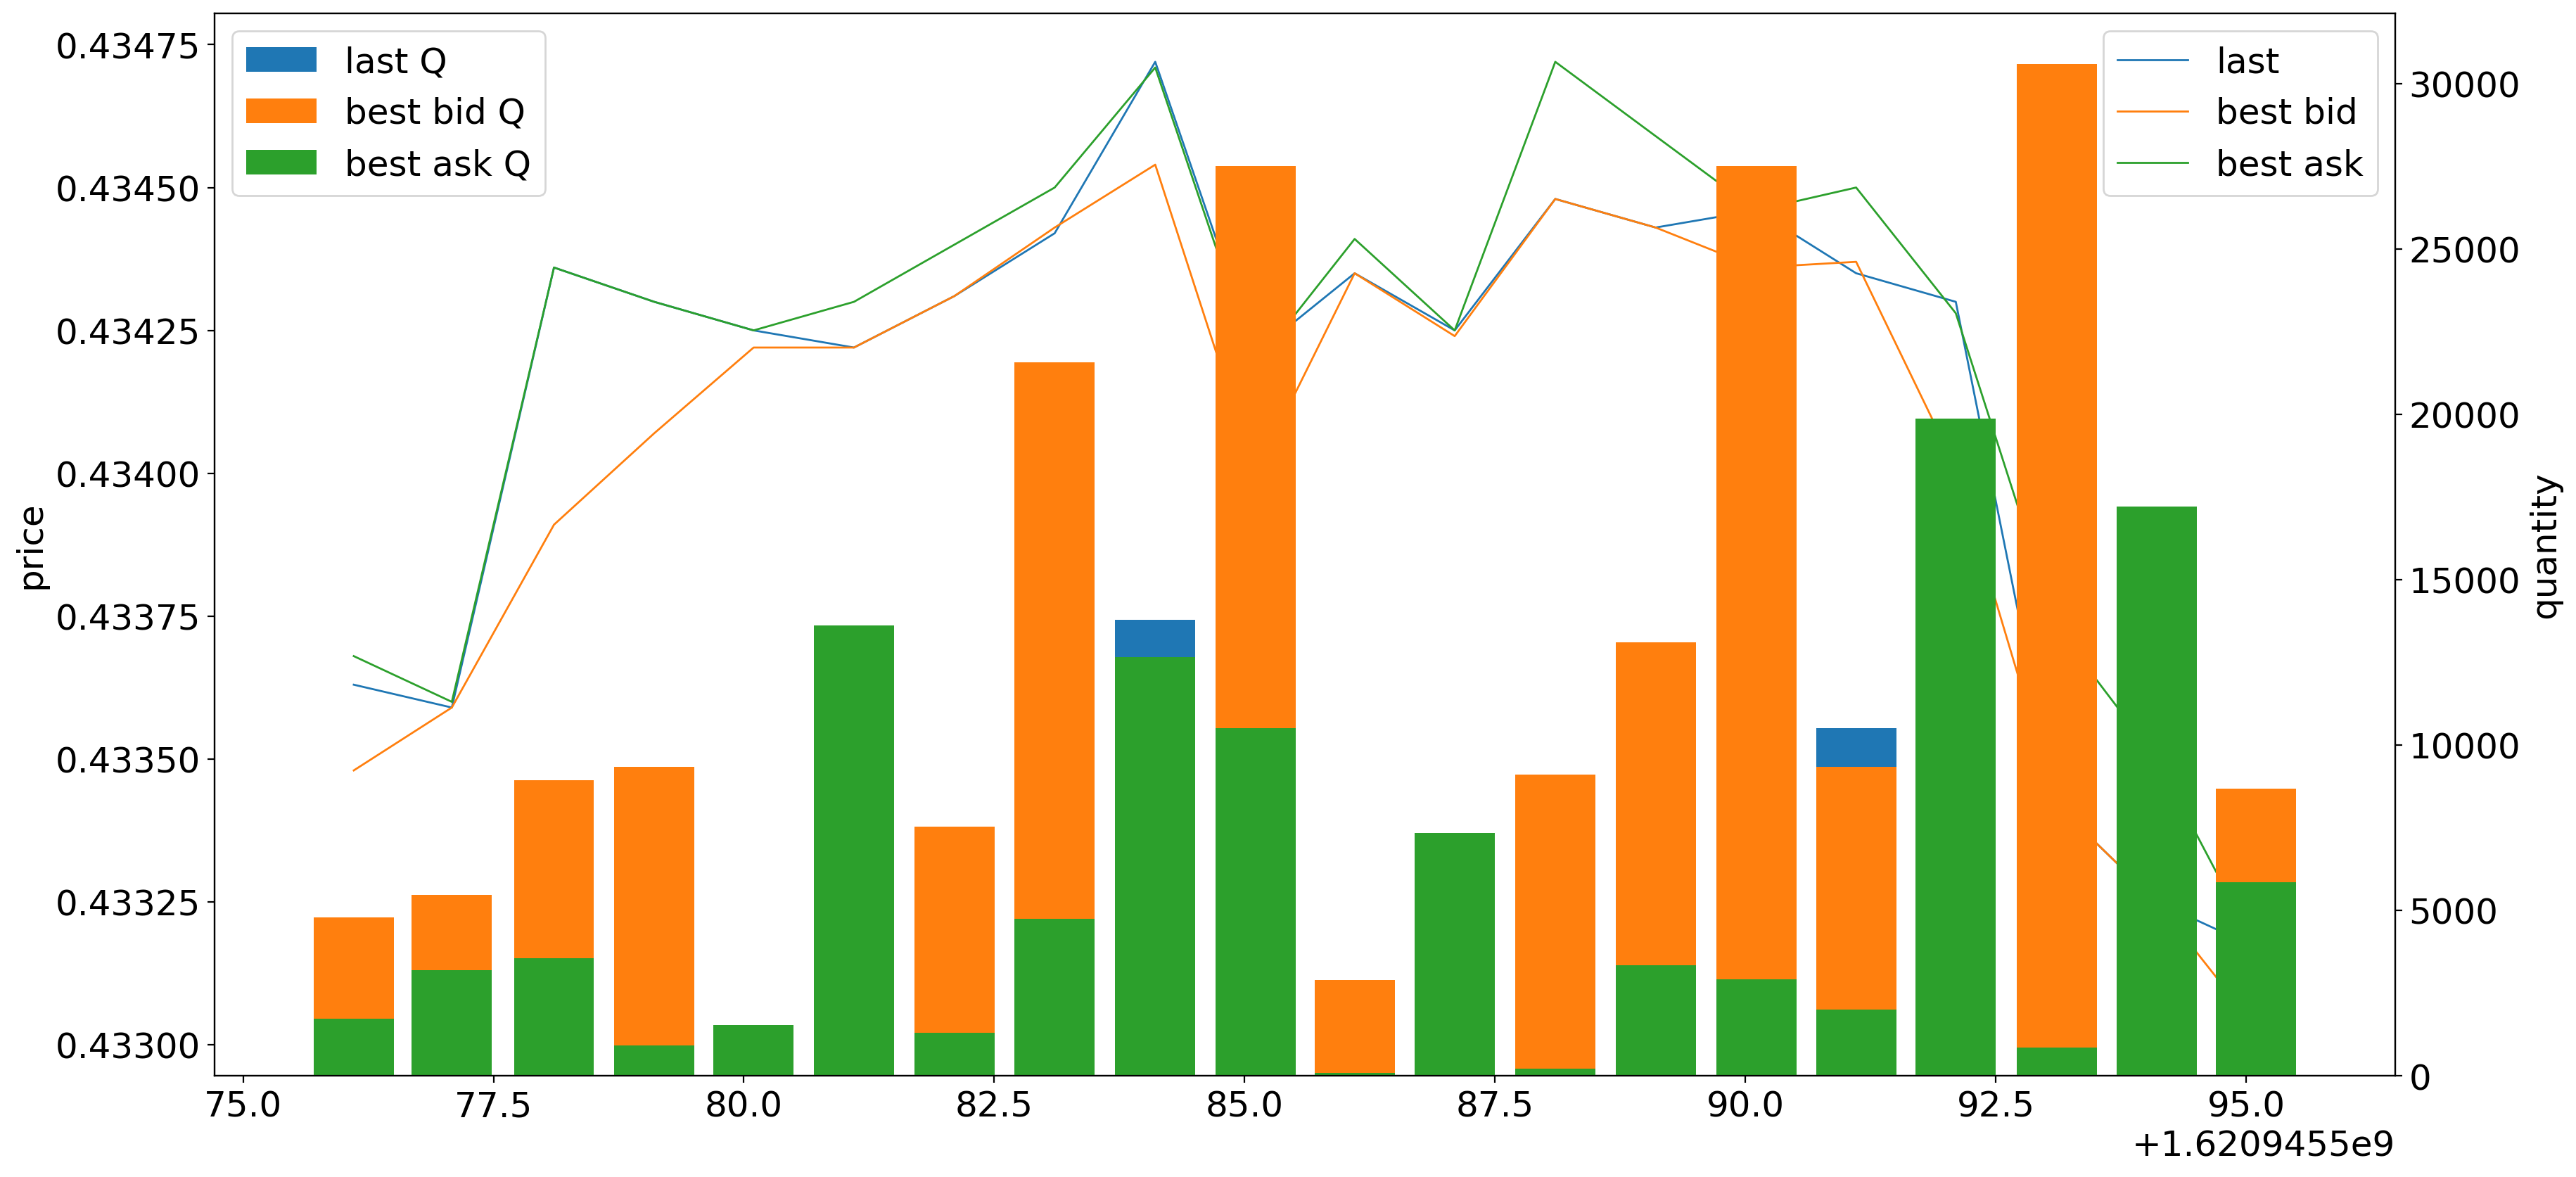

In [14]:
fig, host = plt.subplots(figsize=(20,10))

par1 = host.twinx()

host.plot(times, last_price, linewidth=1)
host.plot(times, best_bid_price, linewidth=1)
host.plot(times, best_ask_price, linewidth=1)

par1.bar(times, last_quantity, linewidth=1)
par1.bar(times, best_bid_quantity, linewidth=1)
par1.bar(times, best_ask_quantity, linewidth=1)

host.set_ylabel("price")
par1.set_ylabel("quantity")

host.legend(["last", "best bid", "best ask"])
par1.legend(["last Q", "best bid Q", "best ask Q"])